In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
import seaborn as sns
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [36]:
plt.rc( 'text', usetex=True ) 
plt.rc('text.latex', preamble=r'\usepackage[cm]{sfmath}')

In [3]:
def start(acc_file, gyro_file):
    try:
        acc_data = pd.read_csv(acc_file)
    except:
        print("[ERROR] An error occured while reading the accelerometer trace. Exiting.")
        return

    try:
        gyro_data = pd.read_csv(gyro_file)
    except:
        print("[ERROR] An error occured while reading the gyroscope trace. Exiting.")
        return

    acc_data.columns = ['sensor','date', 'sec', 'timestamp', 'x', 'y', 'z']
    gyro_data.columns = ['sensor','date', 'sec', 'timestamp', 'x', 'y', 'z']

    # add relative timestamps to data, relative to the first accelerometer sample
    acc_t0 = acc_data['timestamp'].min()

    acc_data['relative_time'] = (acc_data['timestamp'] - acc_t0)
    gyro_data['relative_time'] = (gyro_data['timestamp'] - acc_t0)

    # get to a common time
    acc_data = acc_data[acc_data['timestamp'] >= acc_t0]
    gyro_data = gyro_data[gyro_data['timestamp'] > acc_t0]
    acc_data = acc_data.reset_index(drop=True)
    gyro_data = gyro_data.reset_index(drop=True)

    gyro_start_time = gyro_data['timestamp'].iloc[0]
    while not (acc_data['timestamp'].iloc[0] <= gyro_start_time <= acc_data['timestamp'].iloc[1]):
        acc_data = acc_data.drop(index=0).reset_index(drop=True)

    acc_vals = []

    acc = acc_data['timestamp']
    gyro = gyro_data['timestamp']

    t0 = acc_t0

    for i in range(1, len(acc.values)):
        if i + 1 < len(gyro.values):

            # median is the ideal alignment point
            median = (int((acc.values[i]+acc.values[i-1])/2))

            # difference betwee, two consecutive samples (ms)
            acc_diff   = (acc.values[i] - acc.values[i - 1])

            gyro_sample_diff = (gyro.values[i] - gyro.values[i - 1])

            # difference of the gyro's timestamp from the previous accelerometer sample's timestamp
            gyro_diff = (gyro.values[i - 1] - acc.values[i - 1])

            # deviance of gyro's timestamp from the ideal point. the ideal point is the median of the two consecutive accelerometer samples, we are interested in the absolute deviation of the gyro's timestamp from this ideal point
            gyro_deviance = abs(gyro.values[i - 1] - median)
            # also measure a relative deviation, with respect to the difference between the two consecutive accelerometer samples
            gyro_deviance_rel = (gyro_deviance / (acc_diff / 2)) * 100

            # append these to store (in ms)
            acc_vals.append(list(map(lambda x: x / 1e6, [acc.values[i-1] - t0, acc.values[i] - t0, gyro.values[i - 1] - t0, median - t0, acc_diff, gyro_diff, gyro_deviance, gyro_deviance_rel * 1e6, gyro_sample_diff])))

    diff = pd.DataFrame(acc_vals)
    
    diff.columns = ['acc1', 'acc2', 'gyro1', 'acc_median', 'acc_diff', 'gyro_diff', 'abs_gyro_dev', 'rel_gyro_dev', 'gyro_sample_diff']
    diff['abs_gyro_diff'] = abs(diff['gyro_diff'])

    return diff

In [4]:
def debugInfo(diff):
    # Calculate statistics
    gyro_diff = diff['gyro_diff']
    acc_diff  = diff['acc_diff']

    print(diff)

    # Print statistics
    print("----- STATISTICS -----")
    print(f'Mean Gyro Difference: {gyro_diff.mean():.2f} ms')
    print(f'Mean Absolute Gyro Difference: {abs(gyro_diff).mean():.2f} ms')
    print(f'Standard deviation in Gyro differences: {gyro_diff.std()}')
    print(f'Min gyro diff: {abs(gyro_diff).min()}, Max gyro diff: {abs(gyro_diff).max()}')
    print(f'Mean Sampling delay: {acc_diff.mean():.4f} ms')
    print(f'Mean Sampling delay: {(1 / acc_diff.mean()):.4f} Hz')

    if (abs(gyro_diff)).mean() < 2.5:
        print(" == ELIGIBLE DEVICE")

    # Frequency distribution
    gyro_diff_bins = pd.cut(gyro_diff, bins=4, include_lowest=True)
    freq_table = pd.value_counts(gyro_diff_bins, sort=False)
    freq_percent_table = (freq_table / len(diff)) * 100

    print('\nFrequency Distribution Table:')
    print(pd.concat([freq_table, freq_percent_table], axis=1, keys=['Frequency', 'Percentage']))

In [5]:
def equalize(diffs):
    min_length = min(len(df) for df in diffs)

    # Modify each DataFrame to have the same length as the shortest one
    for i, df in enumerate(diffs):
        diffs[i] = diffs[i][:min_length]

def getDevices(lst_data):
    return list(map(lambda x: x[0].split(",")[1][:-4], lst_data))

In [247]:
def plot_figures(diffs, devices, title="default", nbins=50):
    plt.rcParams.update({'font.size': 18})
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(8, 3))
    
    colors = sns.color_palette()

    # Define the breakpoints for the broken x-axis
    left_range = [0, 3]
    right_range = [97, 100]

    # Plot using the new seaborn kdeplot
    # for i, diff in enumerate(diffs):
    sns.distplot(diffs[0]['rel_gyro_dev'], bins=nbins, kde=True, hist=False, label=devices[0], color=colors[0 + 1], ax=ax1, kde_kws=dict(linewidth=1.5, linestyle=(0, (3, 1, 1, 1, 1, 1))))
    sns.distplot(diffs[1]['rel_gyro_dev'], bins=nbins, kde=True, hist=False, label=devices[1], color=colors[1 + 1], ax=ax2, kde_kws=dict(linewidth=1.5, linestyle='--'))

    # Set the limits for the axes to create the break effect
    # ax = sns.kdeplot(x=diffs[0]['rel_gyro_dev'], ax=ax1, label=devices[0], linewidth=1.5, linestyle=(0, (3, 1, 1, 1, 1, 1)))
    # ax = sns.kdeplot(x=diffs[1]['rel_gyro_dev'], ax=ax2, label=devices[1], color=colors[1 + 1], linewidth=1.5, linestyle='--')
    # ax1.set_xlim(left_range[0], left_range[1])
    # ax2.set_xlim(right_range[0], right_range[1])
    
    # Configure axes appearances
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.yaxis.tick_left()
    
    # Add diagonal lines to indicate the break in the axis
    d = 0.02  # Size of the diagonal lines
    kwargs = dict(color='k', clip_on=False)
    ax1.plot((1 - d, 1 + d), (-d, +d), transform=ax1.transAxes, **kwargs)
    ax1.plot((1 - d, 1 + d), (1-d, 1+d), transform=ax1.transAxes, **kwargs)
    ax2.plot((-d, +d), (-d, +d), transform=ax2.transAxes, **kwargs)
    ax2.plot((-d, +d), (1-d, 1+d), transform=ax2.transAxes, **kwargs)
    # Set labels and legend
    ax1.set_xlabel('Relative Gyro Deviance (\%)')
    ax2.set_xlabel('Relative Gyro Deviance (\%)')
    ax1.set_ylabel('Density')
    # ax2.legend(fontsize=14, loc='upper left')
    # ax1.legend(fontsize=14, loc='upper left')
    ax1.grid(True, linestyle='--')
    ax2.grid(True, linestyle='--')

    # plt.tight_layout()

    # Save if title is not default
    if title != "default":
        plt.savefig(f"{title}.png", dpi=400, bbox_inches='tight')

    plt.show()

/tmp/ipykernel_170958/3654883385.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(diffs[0]['rel_gyro_dev'], bins=nbins, kde=True, hist=False, label=devices[0], color=colors[0 + 1], ax=ax1, kde_kws=dict(linewidth=1.5, linestyle=(0, (3, 1, 1, 1, 1, 1))))
/tmp/ipykernel_170958/3654883385.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.git

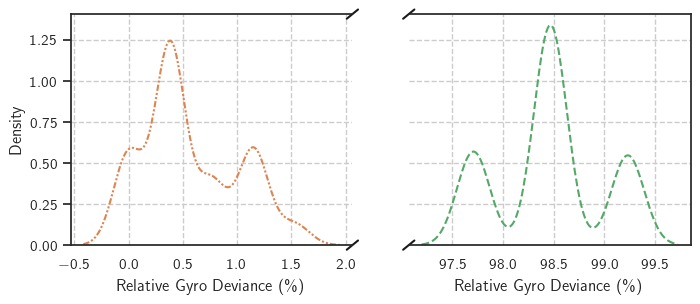

In [248]:
acc = "updatedData/SM-A336E/1712841165.267186/ACC_200-Off.csv"
gyro = "updatedData/SM-A336E/1712841165.267186/GYRO_200-Off.csv"

acc_mag = "updatedData/SM-A336E/1712841165.267186/ACC_200-On.csv"
gyro_mag = "updatedData/SM-A336E/1712841165.267186/GYRO_200-On.csv"
# , "Pixel 5 - after"
devices = ["A33_after", "A33_before"]

# ,(acc_mag, gyro_mag)
categ2 = [(acc_mag, gyro_mag),(acc, gyro)]
diffs = []

for acc_data,gyro_data in categ2:
    diff = start(acc_data,gyro_data)
    diffs.append(diff)
plot_figures(diffs, devices, title="samples_density.png")

In [225]:
def plot(diffs, devices, title="default", nbins=50):
    # sns.set(style="white")  # Set seaborn style for better aesthetics
    plt.rcParams.update({'font.size': 18})
    # fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 14))
    fig, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
    
    colors = sns.color_palette()

    for i, diff in enumerate(diffs):
        # sns.scatterplot(x=range(len(diff)), y='gyro_diff', data=diff, color=colors[i + 2], label=devices[i], ax=ax1, edgecolor=None)
        sns.distplot(diff['rel_gyro_dev'], bins=nbins, kde=True, hist=False, label=devices[i], color=colors[i + 1], ax=ax2, kde_kws=dict(linewidth=2))
        # sns.displot(data=diff, x='rel_gyrp')
        # ax2.hist(diff['gyro_diff'], bins=nbins, range=(0,5), color=colors[i + 1], label=devices[i], edgecolor='black')

    # scatter plot
    # ax1.axhline(0, color="black", linestyle='--', linewidth=2, label='Accelerometer sample')
    # ax1.axhline(2.5, color=colors[0], linestyle='--', linewidth=2, label='Ideal temporal misalignment')
    # ax1.axhline(5, color="black", linestyle='--', linewidth=2)

    # ax1.set_xlabel('Time', fontsize=26)
    # ax1.set_ylabel('Sample deviance (ms)', fontsize=26)
    # ax1.set_ylim([-0.5,5.5])
    # ax1.set_yticks(np.arange(-0.5, 5.5, 0.5))
    
    # ax1.legend(fontsize=20, loc='lower left')
    # ax1.minorticks_on()
    # ax1.grid(True, which='major', linestyle='-')
    # ax1.grid(True, which='minor', linestyle='--', axis='y')
    
    # distribution plot
    ax2.set_xlabel('Absolute Gyro Deviance (ms)', fontsize=26)
    ax2.set_ylabel('Number of Samples', fontsize=26)

    # ax1.tick_params(axis='x', labelsize=26)
    # ax1.tick_params(axis='y', labelsize=26)
    ax2.tick_params(axis='x', labelsize=26)
    ax2.tick_params(axis='y', labelsize=26)
    
    # ax2.set_ylim([0, 100])
    # ax2.set_xlim([4.05, 4.12])
    ax2.legend(fontsize=20, loc='upper left')
    ax2.grid(True, linestyle='--')

    # plt.subplots_adjust(wspace=0.3)
    plt.tight_layout()
    if title != "default":
        # extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        plt.savefig(f"{title}.png", dpi=400, bbox_inches='tight')

    plt.show()

/tmp/ipykernel_170958/2664324536.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


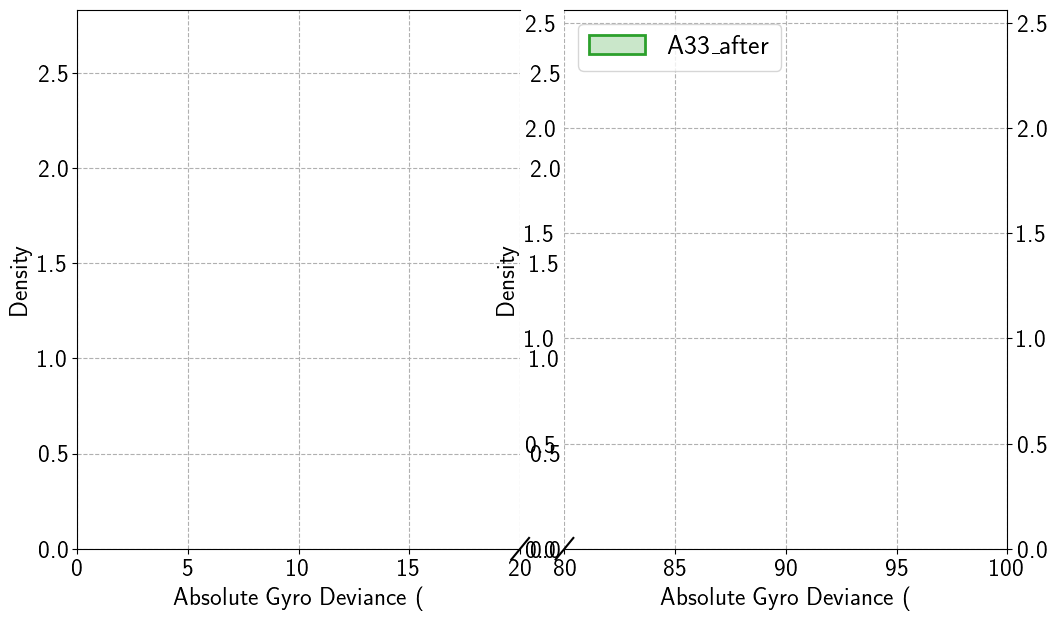

/tmp/ipykernel_170958/1554696948.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(diff['rel_gyro_dev'], bins=nbins, kde=True, hist=False, label=devices[i], color=colors[i + 1], ax=ax2, kde_kws=dict(linewidth=2))
/tmp/ipykernel_170958/1554696948.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750

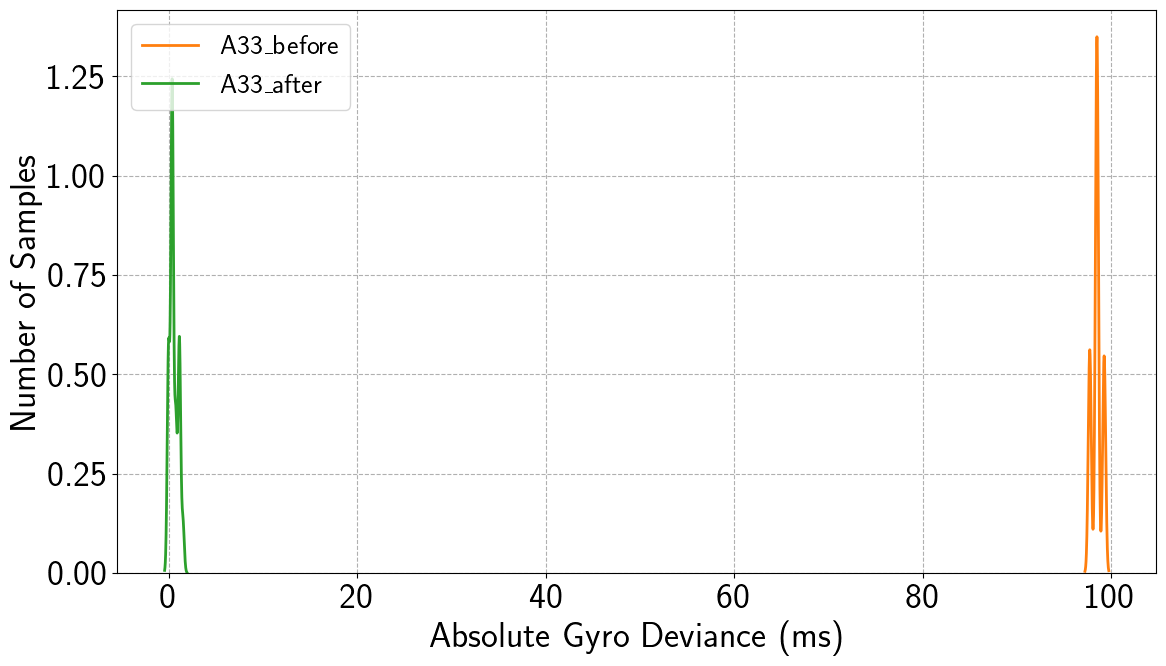

In [33]:
acc = "updatedData/SM-A336E/1712841165.267186/ACC_200-Off.csv"
gyro = "updatedData/SM-A336E/1712841165.267186/GYRO_200-Off.csv"

acc_mag = "updatedData/SM-A336E/1712841165.267186/ACC_200-On.csv"
gyro_mag = "updatedData/SM-A336E/1712841165.267186/GYRO_200-On.csv"
# , "Pixel 5 - after"
devices = ["A33_before", "A33_after"]

# ,(acc_mag, gyro_mag)
categ2 = [(acc, gyro),(acc_mag, gyro_mag)]
diffs = []

for acc_data,gyro_data in categ2:
    diff = start(acc_data,gyro_data)
    diffs.append(diff)

equalize(diffs)
plot(diffs, devices, nbins=4, title="pixel5response-before")

Text(0, 0.5, 'value')

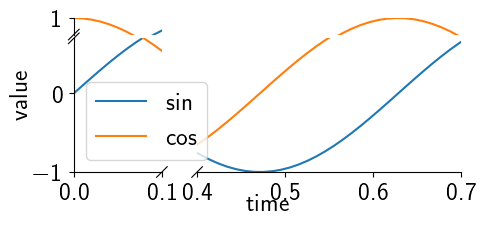

In [34]:
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
import numpy as np

fig = plt.figure(figsize=(5, 2))
bax = brokenaxes(xlims=((0, .1), (.4, .7)), ylims=((-1, .7), (.79, 1)), hspace=.05)
x = np.linspace(0, 1, 100)
bax.plot(x, np.sin(10 * x), label='sin')
bax.plot(x, np.cos(10 * x), label='cos')
bax.legend(loc=3)
bax.set_xlabel('time')
bax.set_ylabel('value')

In [ ]:
categ2 = [(acc, gyro)]
diffs = []

for acc_data,gyro_data in categ2:
    diff = start(acc_data,gyro_data)
    diffs.append(diff)

# equalize(diffs)
plot(diffs, "A33-no-mag", nbins=4, title="A33-before")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


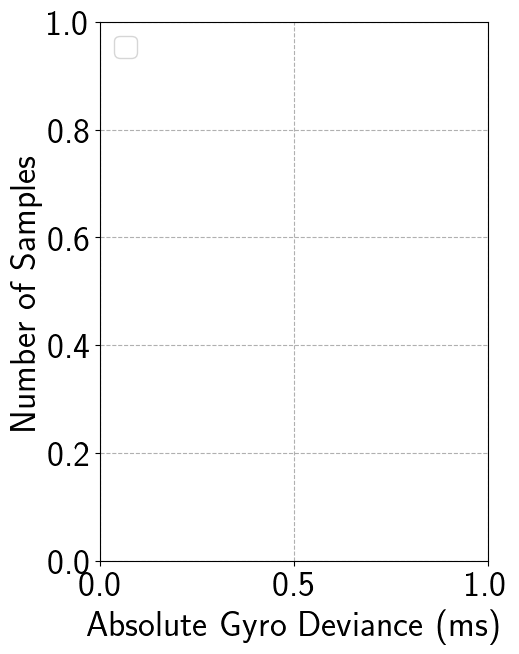

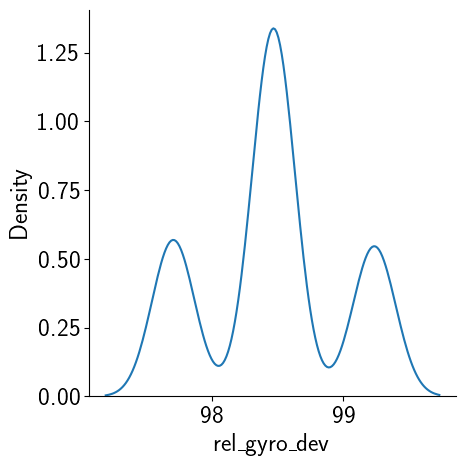

In [26]:
categ2 = [(acc, gyro)]
diffs = []

for acc_data,gyro_data in categ2:
    diff = start(acc_data,gyro_data)
    diffs.append(diff)

# equalize(diffs)
plot(diffs, "A33-no-mag", nbins=4, title="A33-before")

/tmp/ipykernel_170958/1685681036.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(diff['rel_gyro_dev'], bins=nbins, kde=True, hist=False, label=devices[i], color=colors[i + 1], ax=ax2, kde_kws=dict(linewidth=2))


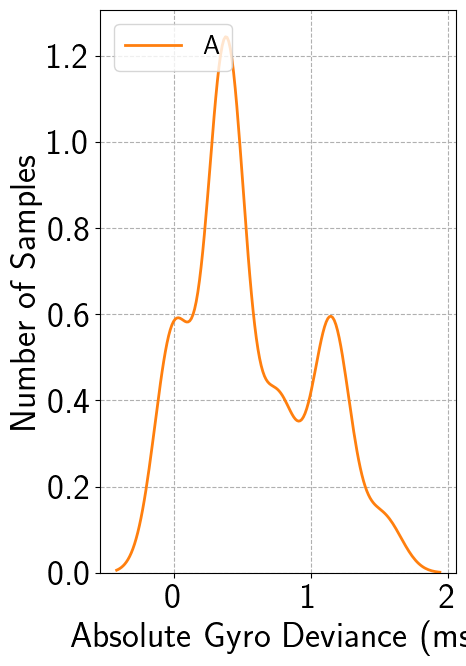

In [22]:
categ2 = [(acc_mag, gyro_mag)]
diffs = []

for acc_data,gyro_data in categ2:
    diff = start(acc_data,gyro_data)
    diffs.append(diff)

# equalize(diffs)
plot(diffs, "A33-with-mag", nbins=4, title="A33-after")

/home/rafay/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/rafay/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


TypeError: __init__() got an unexpected keyword argument 'bgcolor'

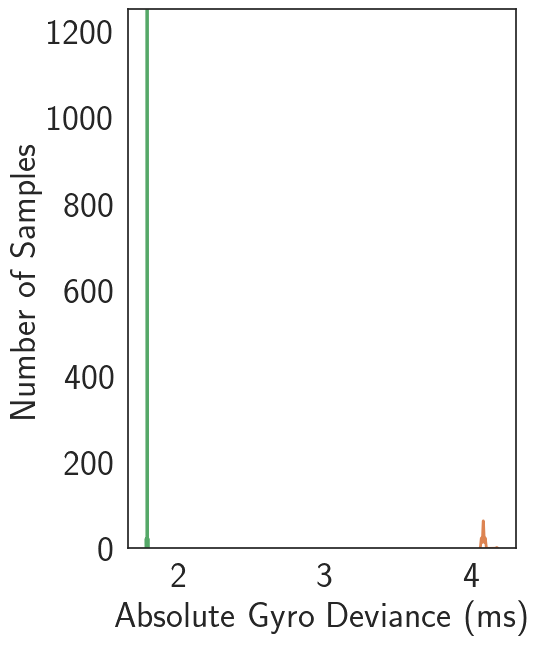

In [259]:
acc = "data/SoomroNew/0k.apk/Accelerometer_data.csv"
gyro = "data/SoomroNew/0k.apk/Gyroscope_data.csv"

acc_mag = "data/SoomroNew/5k.apk/Accelerometer_data.csv"
gyro_mag = "data/SoomroNew/5k.apk/Gyroscope_data.csv"
# , "Pixel 5 - after"
devices = ["Pixel 5 - before mag", "Pixel 5 - after mag"]

# ,(acc_mag, gyro_mag)
categ2 = [(acc, gyro),(acc_mag, gyro_mag)]
diffs = []

for acc_data,gyro_data in categ2:
    diff = start(acc_data,gyro_data)
diffs.append(diff)

equalize(diffs)
plot(diffs, devices, nbins=4, title="pixel5response-both")

In [251]:
# load the data from the csv file
acc = "updatedData/SM-A336E/1712841165.267186/ACC_200-Off.csv"
gyro = "updatedData/SM-A336E/1712841165.267186/GYRO_200-Off.csv"

acc_mag = "updatedData/SM-A336E/1712841165.267186/ACC_200-On.csv"
gyro_mag = "updatedData/SM-A336E/1712841165.267186/GYRO_200-On.csv"
# , "Pixel 5 - after"
devices = ["A33_before", "A33_after"]

diffs = []
devices = ['Pixel 5', 'One Plus 10']

for acc_data,gyro_data in after_mag:
    diff = start(acc_data,gyro_data)
    # debugInfo(diff)
    diffs.append(diff)

equalize(diffs)
plot(diffs, devices, title="with_mag")

[ERROR] An error occured while reading the accelerometer trace. Exiting.
[ERROR] An error occured while reading the accelerometer trace. Exiting.


TypeError: object of type 'NoneType' has no len()

/tmp/ipykernel_170958/1554696948.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(diff['rel_gyro_dev'], bins=nbins, kde=True, hist=False, label=devices[i], color=colors[i + 1], ax=ax2, kde_kws=dict(linewidth=2))


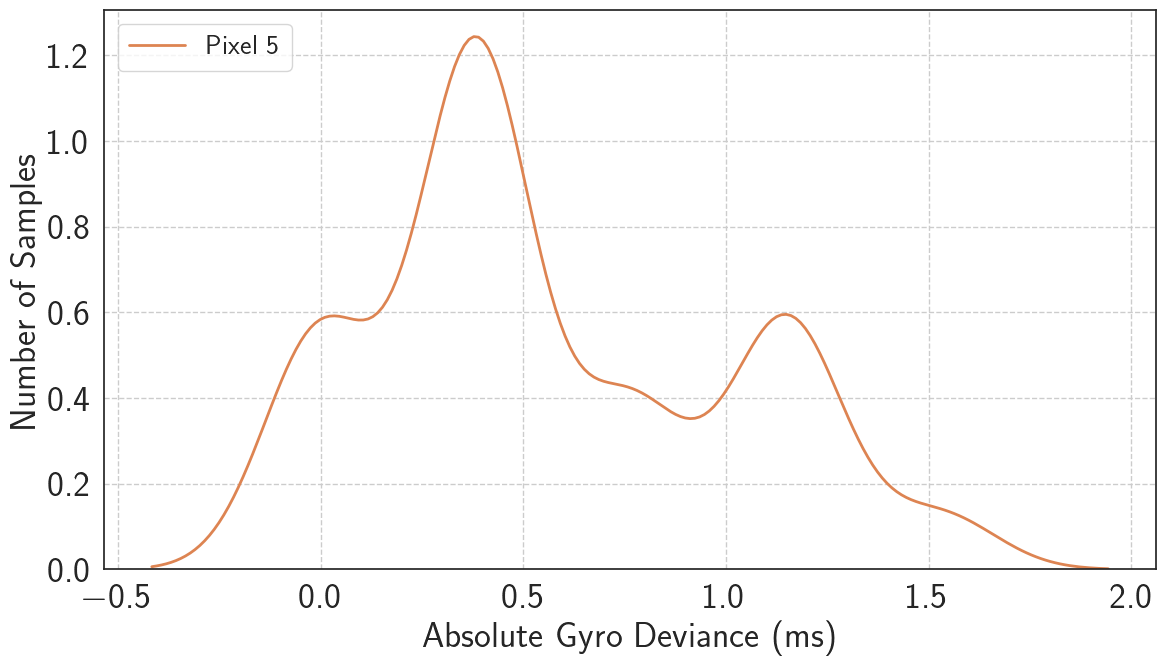

In [252]:
# load the data from the csv file
acc1 = "data/rafay/app-acc-gyro.apk/Accelerometer_20231121_044815,Infinix X680B.csv"
gyro1 = "data/rafay/app-acc-gyro.apk/Gyroscope_20231121_044815,Infinix X680B.csv"

acc2 = "data/Esha/app-acc-gyro.apk/Accelerometer_20231201_165838,SM-A505F.csv"
gyro2 = "data/Esha/app-acc-gyro.apk/Gyroscope_20231201_165838,SM-A505F.csv"

acc3 = "data/ahmedog/acc_nomag.csv"
gyro3 = "data/ahmedog/gyro_nomag.csv"

after_mag = [(acc1,gyro1),(acc2,gyro2),(acc3,gyro3)]

categ2 = [(acc, gyro),(acc_mag, gyro_mag)]
diffs = []

for acc_data,gyro_data in categ2:
    diff = start(acc_data,gyro_data)
diffs.append(diff)

equalize(diffs)
plot(diffs, devices, title="no_mag")

In [ ]:
# PIXEL
# acc = "data/Soomro2/app-acc-gyro.apk/Accelerometer_20231201_171718,Pixel 5.csv"
# gyro = "data/Soomro2/app-acc-gyro.apk/Gyroscope_20231201_171718,Pixel 5.csv"

# acc_mag = "data/Soomro2/app-acc-mag-gyro.apk/Accelerometer_20231201_171834,Pixel 5.csv"
# gyro_mag = "data/Soomro2/app-acc-mag-gyro.apk/Gyroscope_20231201_171834,Pixel 5.csv"
acc = "data/SoomroNew/0k.apk/Accelerometer_data.csv"
gyro = "data/SoomroNew/0k.apk/Gyroscope_data.csv"

acc_mag = "data/SoomroNew/5k.apk/Accelerometer_data.csv"
gyro_mag = "data/SoomroNew/5k.apk/Gyroscope_data.csv"
# , "Pixel 5 - after"
devices = ["Pixel 5 - before", "Pixel 5 - after"]

# ,(acc_mag, gyro_mag)
categ2 = [(acc,gyro), [acc_mag, gyro_mag]]
diffs = []

for acc_data,gyro_data in categ2:
    diff = start(acc_data,gyro_data)
    diffs.append(diff)

equalize(diffs)
plot(diffs, devices, title="pixel5response")

In [ ]:
# PIXEL
acc1 = "data/"
gyro1 = "data/Soomro2/app-acc-gyro.apk/Gyroscope_20231201_171718,Pixel 5.csv"

acc_mag = "data/Soomro2/app-acc-mag-gyro.apk/Accelerometer_20231201_171834,Pixel 5.csv"
gyro_mag = "data/Soomro2/app-acc-mag-gyro.apk/Gyroscope_20231201_171834,Pixel 5.csv"
# , "Pixel 5 - after"
devices = ["Pixel 5 - before"]

# ,(acc_mag, gyro_mag)
categ2 = [(acc,gyro)]
diffs = []

for acc_data,gyro_data in categ2:
    diff = start(acc_data,gyro_data)
    diffs.append(diff)

equalize(diffs)
plot(diffs, devices, title="pixel5response")

In [ ]:
acc = "data/Haris/app-acc-gyro.apk/Accelerometer_20231201_163738,Redmi Note 9 Pro.csv"
gyro = "data/Haris/app-acc-gyro.apk/Gyroscope_20231201_163738,Redmi Note 9 Pro.csv"

lst = [(acc,gyro)]

devices = getDevices(lst)

diff = start(acc, gyro)

plot([diff], devices)